# NLP Project

In [3]:
#import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
import re
import string 
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

In [4]:
#load dataset
train_data = pd.read_csv(r"C:\Users\gopic\Downloads\train_data.csv")
train_labels = pd.read_csv(r"C:\Users\gopic\Downloads\train_label.csv")
test_data = pd.read_csv(r"C:\Users\gopic\Downloads\test_data.csv")
sample_submission = pd.read_csv(r"C:\Users\gopic\Downloads\sample_submission.csv")

print("Train Data Shape:", train_data.shape)
print('\n')
print("Train Labels Shape:", train_labels.shape)
print('\n')
print("Test Data Shape:", test_data.shape)
print('\n')
print("Sample Submission Shape:", sample_submission.shape)

Train Data Shape: (41569, 2)


Train Labels Shape: (75170, 2)


Test Data Shape: (10393, 2)


Sample Submission Shape: (10393, 16)


In [5]:
#merge train data and labels
df = train_data.merge(train_labels , on='id')
df.head()

,text,id,label
0,"Keep your gloves, hats, coats and jackets toge...",122885,Assembly Required
1,"Keep your gloves, hats, coats and jackets toge...",122885,Finish
2,"Keep your gloves, hats, coats and jackets toge...",122885,Hardware Included
3,The Home Dynamix Serendipity Ivory 5 ft. 2 in....,188958,Commercial / Residential
4,The Home Dynamix Serendipity Ivory 5 ft. 2 in....,188958,Features


In [6]:
#Basic Data Understanding

print("Columns in the dataset:", df.columns)
print('\n')
print("Data Types:\n", df.dtypes)
print('\n')
print('Data Summary:' , df.info())
print('\n')
print("Missing Values in each column:\n", df.isnull().sum())
print('\n')
print('value counts of target variable:\n', df['label'].value_counts())

Columns in the dataset: Index(['text', 'id', 'label'], dtype='object')


Data Types:
 text     object
id        int64
label    object
dtype: object


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75170 entries, 0 to 75169
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    75170 non-null  object
 1   id      75170 non-null  int64 
 2   label   75170 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
Data Summary: None


Missing Values in each column:
 text     0
id       0
label    0
dtype: int64


value counts of target variable:
 label
Indoor/Outdoor              9420
Commercial / Residential    6866
ENERGY STAR Certified       6509
Hardware Included           5471
Package Quantity            4995
Tools Product Type          4708
Voltage (volts)             4688
Color                       4505
Included                    4465
Flooring Product Type       4422
Assembly Required           4266
Wattage 

In [62]:
#Building model
#Text Preprocessing function(Noise Removal & Cleaning)

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\s+|www.\S+', '', text)

    # Remove Numbers
    text = re.sub(r'\d+', '', text)

    # Remove Punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove Extra Whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove Stopwords and Lemmatization
    words = text.split()
    text = ' '.join([lemmatizer.lemmatize(word)
                      for word in words 
                      if word not in stop_words])
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gopic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gopic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [63]:
#Apply cleaning to all data

df['clean_text'] = df['text'].apply(clean_text)
test_data['clean_text'] = test_data['text'].apply(clean_text)

In [9]:
df.head()

,text,id,label,clean_text
0,"Keep your gloves, hats, coats and jackets toge...",122885,Assembly Required,keep glove hat coat jacket together need entry...
1,"Keep your gloves, hats, coats and jackets toge...",122885,Finish,keep glove hat coat jacket together need entry...
2,"Keep your gloves, hats, coats and jackets toge...",122885,Hardware Included,keep glove hat coat jacket together need entry...
3,The Home Dynamix Serendipity Ivory 5 ft. 2 in....,188958,Commercial / Residential,home dynamix serendipity ivory ft x ft area ru...
4,The Home Dynamix Serendipity Ivory 5 ft. 2 in....,188958,Features,home dynamix serendipity ivory ft x ft area ru...


In [10]:
#train-test split
x = df['clean_text']
y = df['label']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
#TF-IDF Vectorization

tfidf = TfidfVectorizer(max_features=20000 , ngram_range=(1,2))
x_train_tfidf = tfidf.fit_transform(x_train)
x_val_tfidf = tfidf.transform(x_val)

test_tfidf = tfidf.transform(test_data['clean_text'])

In [12]:
# Training Multiple Models

# 1. Logistic Regression

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(x_train_tfidf, y_train)

lr_pred = lr_model.predict(x_val_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_val, lr_pred))
print('\n')
print("Classification Report:\n", classification_report(y_val, lr_pred))

Logistic Regression Accuracy: 0.39709990687774377


Classification Report:
                           precision    recall  f1-score   support

       Assembly Required       0.57      0.66      0.61       853
                   Color       0.54      0.47      0.50       901
Commercial / Residential       0.25      0.24      0.24      1373
   ENERGY STAR Certified       0.37      0.48      0.42      1302
                Features       0.29      0.29      0.29       764
                  Finish       0.42      0.39      0.41       720
   Flooring Product Type       0.17      0.20      0.19       885
       Hardware Included       0.46      0.41      0.44      1094
                Included       0.29      0.27      0.28       893
          Indoor/Outdoor       0.28      0.28      0.28      1884
        Package Quantity       0.54      0.57      0.56       999
                   Shape       0.46      0.37      0.41       703
      Tools Product Type       0.74      0.83      0.78       942

In [13]:
# 2. Linear SVM

svm = LinearSVC()
svm.fit(x_train_tfidf, y_train)
svm_pred = svm.predict(x_val_tfidf)

print("Linear SVM Accuracy:", accuracy_score(y_val, svm_pred))
print('\n')
print("Classification Report:\n", classification_report(y_val, svm_pred))

Linear SVM Accuracy: 0.32140481575096447


Classification Report:
                           precision    recall  f1-score   support

       Assembly Required       0.50      0.53      0.52       853
                   Color       0.49      0.45      0.47       901
Commercial / Residential       0.20      0.19      0.20      1373
   ENERGY STAR Certified       0.30      0.33      0.31      1302
                Features       0.19      0.19      0.19       764
                  Finish       0.34      0.34      0.34       720
   Flooring Product Type       0.11      0.13      0.12       885
       Hardware Included       0.38      0.34      0.36      1094
                Included       0.20      0.19      0.19       893
          Indoor/Outdoor       0.21      0.20      0.20      1884
        Package Quantity       0.50      0.54      0.52       999
                   Shape       0.36      0.34      0.35       703
      Tools Product Type       0.70      0.76      0.73       942
        

In [14]:
# 3. Multinomial Naive Bayes

mnb = MultinomialNB()
mnb.fit(x_train_tfidf, y_train)

mnb_pred = mnb.predict(x_val_tfidf)
print("Multinomial Naive Bayes Accuracy:", accuracy_score(y_val, mnb_pred))
print('\n')
print("Classification Report:\n", classification_report(y_val, mnb_pred))

Multinomial Naive Bayes Accuracy: 0.45676466675535454


Classification Report:
                           precision    recall  f1-score   support

       Assembly Required       0.54      0.80      0.64       853
                   Color       0.55      0.41      0.47       901
Commercial / Residential       0.52      0.10      0.17      1373
   ENERGY STAR Certified       0.42      0.66      0.52      1302
                Features       0.34      0.46      0.39       764
                  Finish       0.51      0.49      0.50       720
   Flooring Product Type       0.32      0.61      0.42       885
       Hardware Included       0.51      0.38      0.44      1094
                Included       0.35      0.22      0.27       893
          Indoor/Outdoor       0.44      0.18      0.26      1884
        Package Quantity       0.55      0.63      0.59       999
                   Shape       0.49      0.44      0.47       703
      Tools Product Type       0.66      0.91      0.77      

In [15]:
# 4. Random Forest Classifier

#rf = RandomForestClassifier(n_estimators=300, random_state=42)
#rf.fit(x_train_tfidf, y_train)
#rf_pred = rf.predict(x_val_tfidf)

#print("Random Forest Classifier Accuracy:", accuracy_score(y_val, rf_pred))
#print('\n')
#print("Classification Report:\n", classification_report(y_val, rf_pred))

In [19]:
#predict on Test Data

best_model = mnb
test_pred = best_model.predict(test_tfidf)
test_pred_prob = best_model.predict_proba(test_tfidf)


In [20]:
#converting raw score to probalities

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
test_probs = scaler.fit_transform(test_pred_prob)

In [23]:
#Final file
submission = sample_submission.copy()
submission.iloc[:, 1:] = test_probs  # keep id column as it is

submission.head()


,id,Indoor/Outdoor,Commercial / Residential,ENERGY STAR Certified,Hardware Included,Package Quantity,Flooring Product Type,Color,Tools Product Type,Included,Voltage (volts),Assembly Required,Features,Wattage (watts),Finish,Shape
0,114689,9.715723e-06,1.966898e-05,5.172861e-06,3.918595e-06,6.133573e-06,3.124298e-02,2.099113e-06,1.555964e-05,0.000021,6.360238e-03,9.623502e-01,1.845243e-05,0.000143,0.000033,3.342101e-06
1,183172,8.422119e-07,7.630747e-07,3.217242e-08,3.801721e-07,2.603794e-07,1.777834e-07,6.241052e-09,1.930980e-07,0.000002,1.276257e-07,5.673902e-07,1.342291e-07,0.940772,0.059320,3.281803e-07
2,217304,1.066102e-02,9.502959e-03,1.587412e-03,6.300213e-03,1.115285e-03,1.081509e-02,1.896430e-04,8.518759e-03,0.035898,2.474213e-02,8.109747e-01,1.742938e-02,0.034116,0.035535,3.436037e-03
3,184115,8.055359e-06,2.139766e-03,1.976946e-01,1.762853e-06,5.360617e-06,6.854476e-06,7.952206e-01,5.468616e-06,0.000008,5.194539e-02,4.373678e-06,6.107782e-05,0.000003,0.000002,1.831248e-06
4,103786,2.997477e-02,5.680895e-01,3.679275e-02,9.733436e-03,1.228546e-02,1.226539e-02,4.436051e-03,1.149311e-01,0.021866,1.029989e-01,6.665259e-03,8.697284e-02,0.000777,0.002728,2.246730e-03


In [24]:
submission.to_csv("final_submission.csv", index=False)
print("Submission file saved!")


Submission file saved!


# EDA (Exploratory Data Anlaysis):


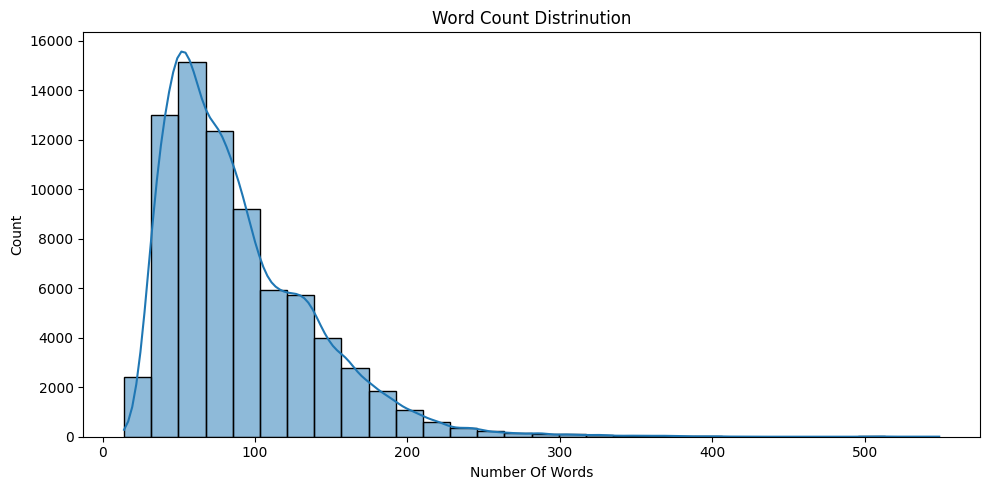

In [30]:
#Number of words per paragraph

df['word_count'] = df['clean_text'].apply(lambda x : len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(df['word_count'] , bins=30 , kde=True)
plt.title('Word Count Distrinution')
plt.xlabel('Number Of Words')
plt.tight_layout()
plt.show()

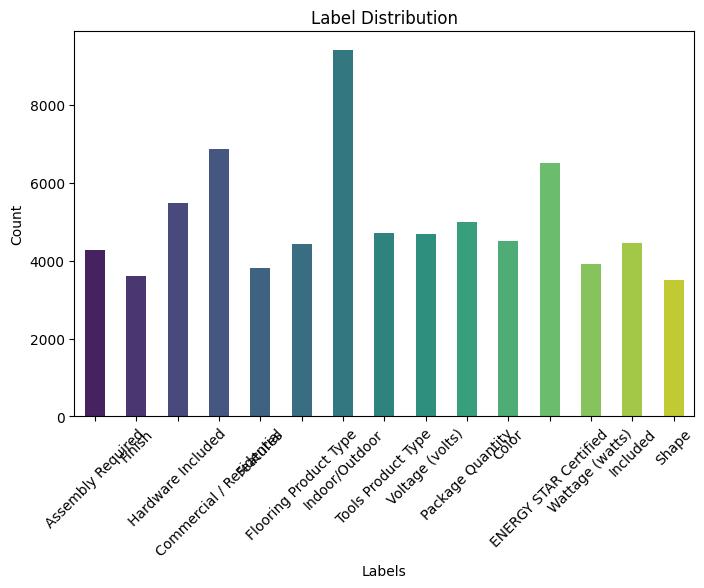

In [40]:
#Label Distribution

plt.figure(figsize=(8,5))
sns.countplot(data=df , x = 'label' , palette='viridis' , gap=0.4)
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.show()

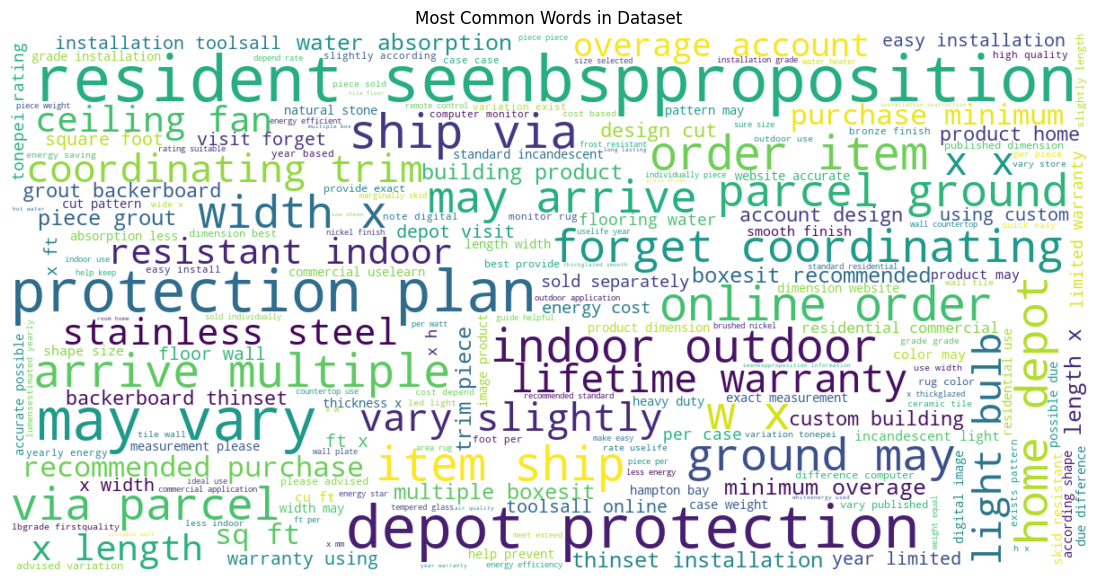

In [42]:
# WordCloud -- Most Frequent Words

from wordcloud import WordCloud

all_words = ' '.join(df['clean_text'])

wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(all_words)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Dataset')
plt.show()

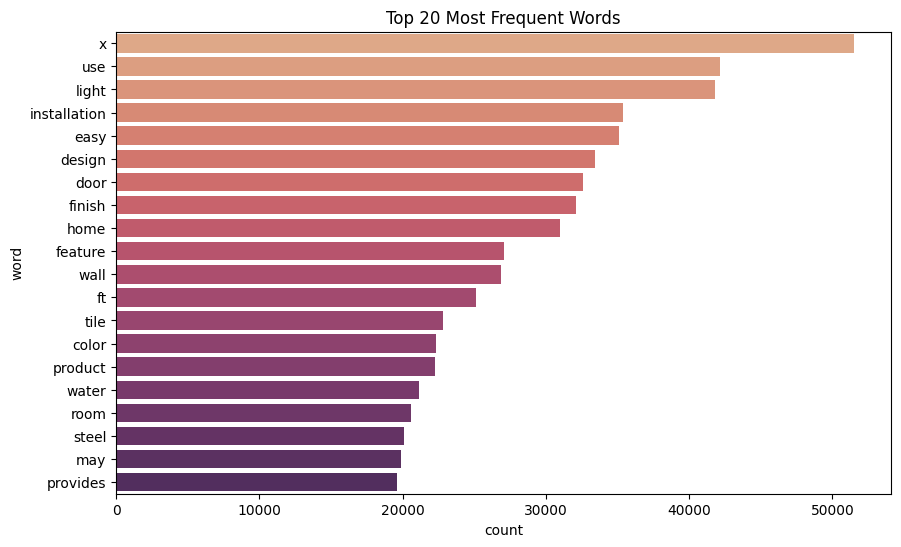

In [43]:
# Most Common Words (Unigram)

from collections import Counter

words = all_words.split()
word_freq = Counter(words).most_common(20)

words_df = pd.DataFrame(word_freq , columns=['word' , 'count'])


plt.figure(figsize=(10,6))
sns.barplot(data=words_df, x='count', y='word', palette='flare')
plt.title("Top 20 Most Frequent Words")
plt.show()

In [ ]:
# N-Gram Analysis (Bigram and Trigram)

from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, ngram_range=(2,2), n=20):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    
    return pd.DataFrame(words_freq, columns=['ngram', 'count'])


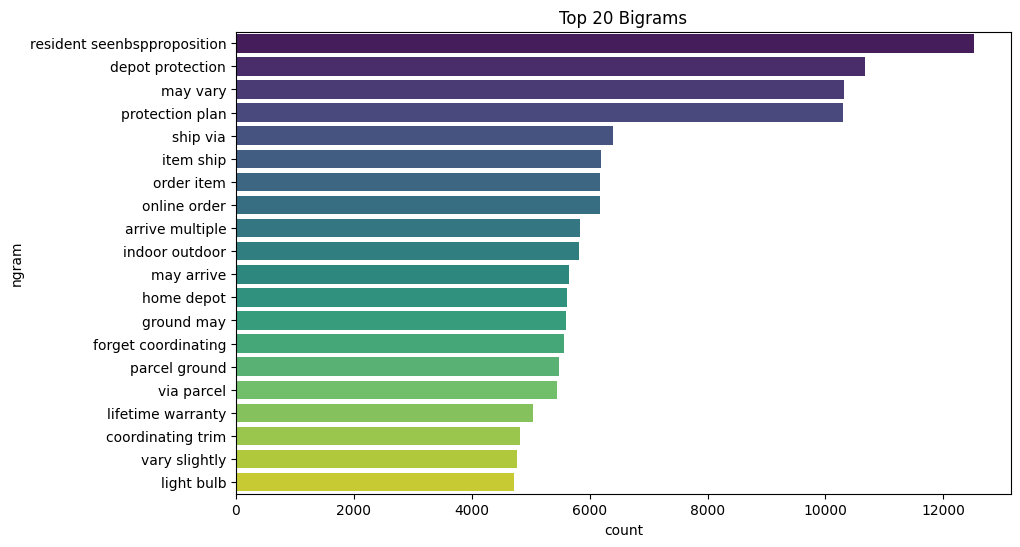

In [ ]:
# Top 20 Bigrams
top_bigrams = get_top_ngrams(df['clean_text'], (2,2))

plt.figure(figsize=(10,6))
sns.barplot(data=top_bigrams, x='count', y='ngram', palette='viridis')
plt.title("Top 20 Bigrams")
plt.show()


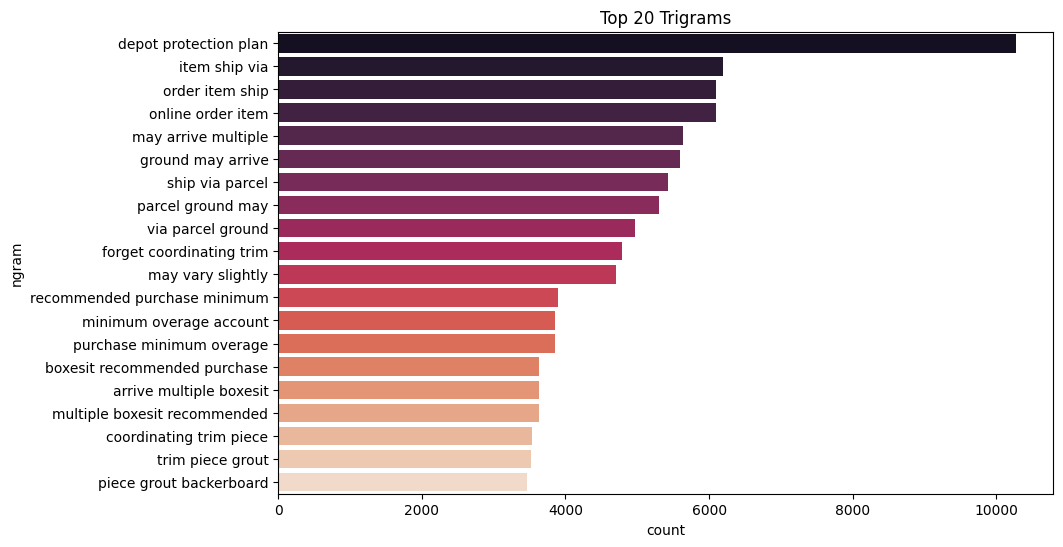

In [46]:
# Top 20 Trigrams
top_trigrams = get_top_ngrams(df['clean_text'], (3,3))

plt.figure(figsize=(10,6))
sns.barplot(data=top_trigrams, x='count', y='ngram', palette='rocket')
plt.title("Top 20 Trigrams")
plt.show()


# Error Analysis

### Name of Variables we Have
##### X_valid 
##### y_valid 
##### X_valid_tfidf (TF-IDF matrix for X_valid)
##### test_tfidf 
##### best_model
##### df —  text ,clean_text ,label 


Classification Report: 

                          precision    recall  f1-score   support

       Assembly Required     0.5379    0.7984    0.6428       853
                   Color     0.5501    0.4140    0.4725       901
Commercial / Residential     0.5165    0.1027    0.1713      1373
   ENERGY STAR Certified     0.4226    0.6628    0.5161      1302
                Features     0.3418    0.4568    0.3910       764
                  Finish     0.5057    0.4903    0.4979       720
   Flooring Product Type     0.3198    0.6056    0.4186       885
       Hardware Included     0.5104    0.3830    0.4376      1094
                Included     0.3509    0.2161    0.2675       893
          Indoor/Outdoor     0.4430    0.1794    0.2554      1884
        Package Quantity     0.5523    0.6346    0.5906       999
                   Shape     0.4944    0.4410    0.4662       703
      Tools Product Type     0.6618    0.9140    0.7677       942
         Voltage (volts)     0.3912    0.6482    0

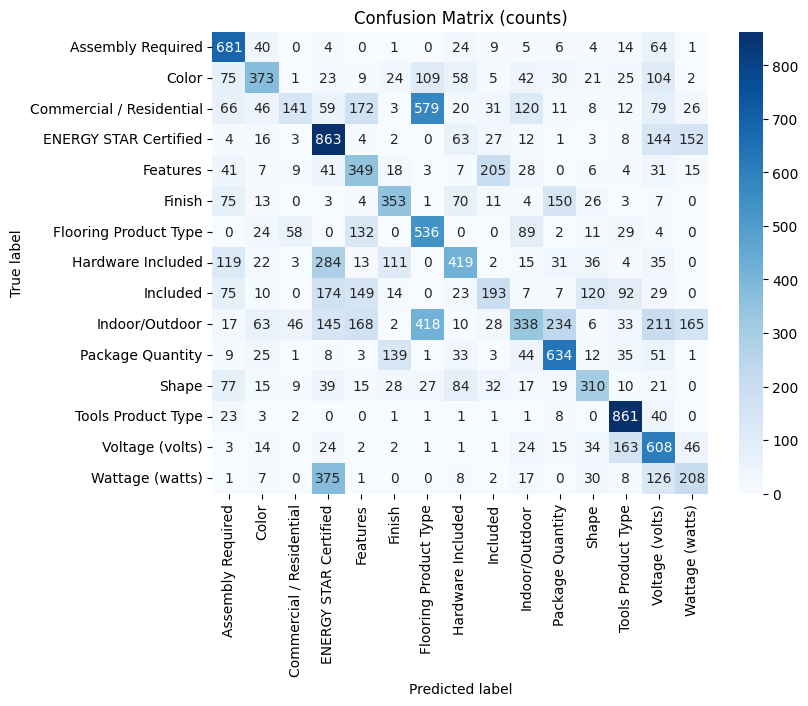

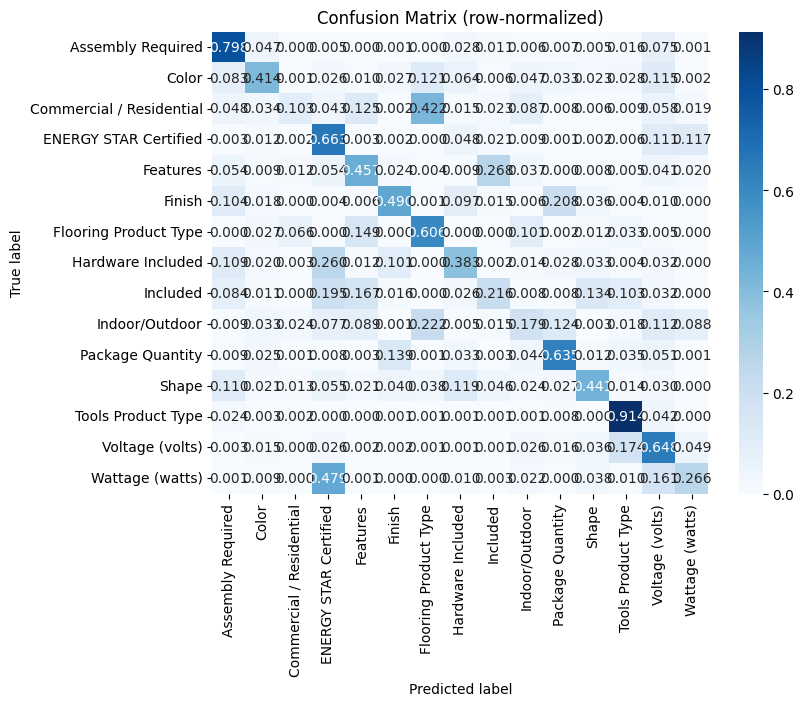

In [51]:
# 1. Confusion Matrix and Classification Report

from sklearn.metrics import confusion_matrix , classification_report

# prediction on vairable set
y_pred = best_model.predict(x_val_tfidf)

#Classification Report

print('Classification Report: \n')
print(classification_report(y_val , y_pred , digits=4))

#Confusion Matrix

cm = confusion_matrix(y_val , y_pred)
labels = np.unique(y_val)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix (counts)')
plt.show()

#Normalized 

cm_norm = cm.astype('float') / cm.sum(axis=1)[: , np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(np.round(cm_norm,3), annot=True, fmt='.3f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix (row-normalized)')
plt.show()


In [56]:
# 2. Missclassified Example
# 2. Create a validation dataframe with original text (if df has same indices)
# df should be the original dataframe with columns: 'text', 'clean_text', 'label'
valid_df = df.loc[x_val.index].copy()   # this keeps original row mapping
valid_df = valid_df.reset_index(drop=True)
valid_df['true_label'] = y_val.reset_index(drop=True)
valid_df['pred_label'] = pd.Series(y_pred).reset_index(drop=True)
valid_df['correct'] = valid_df['true_label'] == valid_df['pred_label']

# quick stats
print("Validation size:", len(valid_df))
print("Number of misclassified:", (~valid_df['correct']).sum())

# Save misclassified
misclassified = valid_df[~valid_df['correct']].copy()
misclassified[['id','text','clean_text','true_label','pred_label']].head(20)   # show top 20
misclassified.to_csv("misclassified_examples.csv", index=False)
print("Saved misclassified_examples.csv (top examples shown above).")


Validation size: 15034
Number of misclassified: 8167
Saved misclassified_examples.csv (top examples shown above).


In [57]:
# show top confusions (true->pred) with counts
confusions = misclassified.groupby(['true_label','pred_label']).size().reset_index(name='count').sort_values('count', ascending=False)
confusions.head(20)


,true_label,pred_label,count
30,Commercial / Residential,Flooring Product Type,579
114,Indoor/Outdoor,Flooring Product Type,418
174,Wattage (watts),ENERGY STAR Certified,375
88,Hardware Included,ENERGY STAR Certified,284
117,Indoor/Outdoor,Package Quantity,234
120,Indoor/Outdoor,Voltage (volts),211
59,Features,Included,205
99,Included,ENERGY STAR Certified,174
28,Commercial / Residential,Features,172
112,Indoor/Outdoor,Features,168


In [58]:
misclassified.to_csv("misclassified_full.csv", index=False)
print("misclassified_full.csv")


misclassified_full.csv


In [64]:
import joblib
joblib.dump(best_model, 'model.pkl')
joblib.dump(tfidf, 'tfidf.pkl')

['tfidf.pkl']